<a href="https://colab.research.google.com/github/vivitc/deep-learning-books/blob/master/Trabalho_DL_Books.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabalho Deep Learning - Filtragem colaborativa com avaliações de livros**
## Grupo 7
### - Amanda Ely Patzer
### - James La Rosa
### - Roger William Calderini
### - Vinícius D`Ambros
### - Viviana Terceros Cordova

Neste notebook, desenvolveremos o trabalho com foco em um sistema de recomendação de livros por meio de Deep Learning ("DL") com a utilização das seguintes metodologias: 

- Filtragem Colaborativa com **XX** técnica (a qual possui foco na interação entre usuários e conteúdos, efetuando recomendações com base na atribuição de ratings/pontuações aos conteúdos consumidos); e
- Filtragem Colaborativa com **YY** técnica (a qual possui foco na interação entre usuários e conteúdos, efetuando recomendações com base na atribuição de ratings/pontuações aos conteúdos consumidos); e

Com isso, busca-se desenvolver um modelo de recomendação para usuários dos Estados Unidos (USA) que leve em consideração a filtragem colaborativa (avaliações de cada usuário) e **YYY**, entendendo qual técnica tem mais assertividade.

A base de dados selecionada foi a seguinte: http://www2.informatik.uni-freiburg.de/~cziegler/BX/. Todavia, ao analisarmos os dados por completo e executar uma técnica de machine learning, o código crashed devido ao excesso de dados. Por isso, para compararmos qual método é mais eficaz, aplicou-se o corte de país USA e considerando apenas as avaliações explícitas (1-10), removendo registros com 0.


## 0. Importação das bibliotecas

Upload das bibliotecas que serão utilizadas

In [61]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential
from keras.datasets import mnist

#Visualização
import seaborn as sns
sns.set(style='white', context='notebook', palette='pastel')
#Visualização dos dados
import matplotlib.pyplot as plt

#Used for distribution fitting, and representation
from scipy import stats

#Time measuring for model training
from time import time

#dependência do matplotlib
!pip install msgpack 
#instalação do pacote matplotlib
!pip install matplotlib  
import matplotlib.pyplot as plt 
import pandas as pd  
import statsmodels.api as sm  
import pylab as pl  
import numpy as np  
from patsy import dmatrix  

!pip install wordcloud
from os import path
from PIL import Image

import sklearn as sk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

## 1. Upload da base

Aqui, vamos subir a base 

In [62]:
import pandas as pd  
url_book_rating = 'https://raw.githubusercontent.com/vivitc/deep-learning-books/master/data/BX-Book-Ratings01.csv'
df_book_rating = pd.read_csv(url_book_rating, delimiter=";", encoding="latin1")

In [63]:
display(df_book_rating)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [64]:
import pandas as pd  
url_book = 'https://raw.githubusercontent.com/vivitc/deep-learning-books/master/data/BX-Books01.csv'
df_book = pd.read_csv(url_book, delimiter=";", encoding="latin1")

In [65]:
display(df_book)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271374,440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271375,525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271376,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271377,192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [66]:
import pandas as pd  
url_users = 'https://raw.githubusercontent.com/vivitc/deep-learning-books/master/data/BX-Users01.csv'
df_users = pd.read_csv(url_users, delimiter=";", encoding="latin1", header=0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [67]:
display(df_users)

,User-ID,Location_CT,Location_UF,Location_CY,Age
0,120567,545,rheinland-pfalz,germany,NaN
1,84244,01109,sachsen,germany,40.0
2,151969,1700,fribourg,switzerland,24.0
3,147786,01721,NaN,NaN,37.0
4,160922,3003,tenerife,espaã±a,30.0
...,...,...,...,...,...
277659,257484,zwolle,overijssel,netherlands,25.0
277660,258249,zwolle,NaN,netherlands,26.0
277661,239223,zxcvzxcvzxcvz,abruzzo,italy,32.0
277662,146905,zywiec,slaskie,poland,22.0


## 2. Análise descritiva dos dados
Em seguida, vamos fazer alguns pré-processamentos básicos para conhecer os dados, lembrando os códigos:
- BX-Users: Contém os usuários(`User-ID`) anônimos. Dados demográficos organizados, quando disponíveis (`Location`, `Age`). `Age` com valor NaN, significa que o valor de `Age` nao foi disponibilizado.

- BX-Books: Os livros são identificados pelo ISBN (os inválidos já foram removidos). Informações sobre conteúdo são disponíveis como (`Book-Title`, `Book-Author`, `Year-Of-Publication`, `Publisher`), pelo Amazon Web Services. Se houver mais de 1 autor, só o primeiro é mencionado. Imagens da capa estão disponíveis em pequeno, médio e grande (`Image-URL-S`, `Image-URL-M`, `Image-URL-L`), pelo Amazon Web Services também.

- BX-Book-Ratings: As avaliações dos livros (`Book-Rating`)  são ou explícitas de 1-10 (valores mais altos indicam mais apreciação), ou implicito, expresso por 0.

### *Apesar da base ter diversos países e avaliações, testamos a análise descritiva dos dados e a Filtragem Colaborativa com os dados completos e recebemos uma mensagem de erro devido ao tamanho da Matriz de Interação:*

*Erro: ValueError: Unstacked DataFrame is too big, causing int32 overflow*

*Assim, foram feitos alguns recortes na base para que seja possível trabalhá-la, sendo:*
- *Utilização dos dados referente ao Country USA;*
- *Utilização de livros com avaliações explícitas, ou seja, Ratings de 1-10.*

###2.1 Users (sem normalização)

In [ ]:
#Verificando as estatísticas básicas
df_users.describe

<bound method NDFrame.describe of                                                  User-ID  ...   Age
0                                                 120567  ...   NaN
1                                                  84244  ...  40.0
2                                                 151969  ...  24.0
3                                                 147786  ...  37.0
4                                                 160922  ...  30.0
...                                                  ...  ...   ...
537945                                            278855  ...  50.0
537946                                            278856  ...   NaN
537947                                            278857  ...   NaN
537948                                            278858  ...   NaN
537949  >>>>>>> 08ef6012be10d0cfa7c55409e30d87a2f4248b33  ...   NaN

[537950 rows x 5 columns]>

In [ ]:
#Entendendo se temos muitos valores faltantes
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537950 entries, 0 to 537949
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   User-ID      537950 non-null  object 
 1   Location_CT  536828 non-null  object 
 2   Location_UF  522918 non-null  object 
 3   Location_CY  529777 non-null  object 
 4   Age          322928 non-null  float64
dtypes: float64(1), object(4)
memory usage: 20.5+ MB


In [ ]:
total = df_users.isnull().sum().sort_values(ascending = False)
percent = (df_users.isnull().sum()/df_users.isnull().count()*100).sort_values(ascending = False)
missing_df_users  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_df_users

,Total,Percent
Age,215022,39.970629
Location_UF,15032,2.794312
Location_CY,8173,1.519286
Location_CT,1122,0.208570
User-ID,0,0.000000


24.0    10897
25.0    10773
26.0    10614
23.0    10435
27.0    10322
28.0    10268
29.0    10129
32.0     9193
30.0     9179
33.0     9026
22.0     8964
34.0     8959
31.0     8944
21.0     8471
35.0     8066
20.0     7745
19.0     7537
36.0     7509
18.0     7082
37.0     6895
Name: Age, dtype: int64

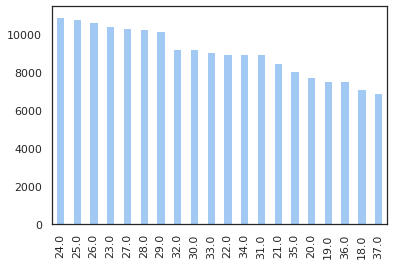

In [ ]:
# Ratings de 0 a 10
Users_Age=df_users["Age"].value_counts(ascending=False)
Users_Age.head(20).plot.bar()
Users_Age.head(20)



[(0.0, 0.035), (1.0, 100.0)]

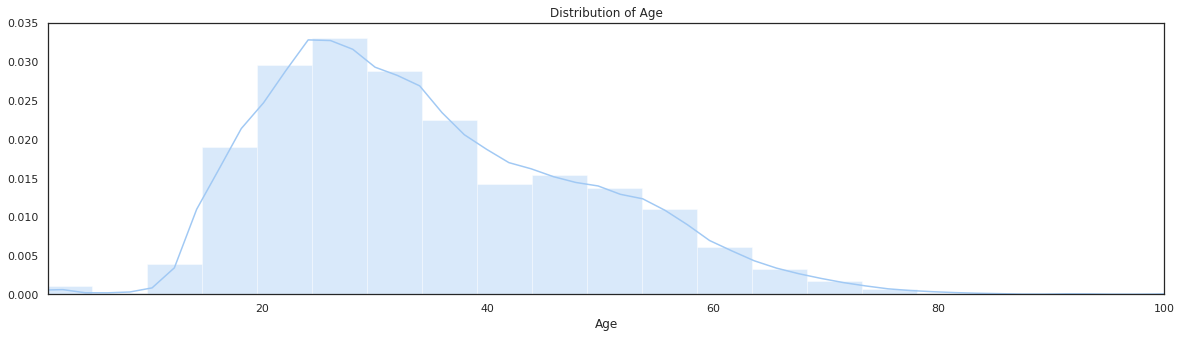

In [ ]:
#Histograma com distribuição de idade
plt.figure(figsize=(20,5))
plt.title("Distribution of Age")
ax = sns.distplot(df_users["Age"])
ax.set(xlim=(1, 100), ylim=(0, 0.035))


###2.2 Books

In [ ]:
#Verificando as estatísticas básicas
df_book.describe(exclude=[np.object])

,Year-Of-Publication
count,271379.000000
mean,1959.763394
std,257.983943
min,0.000000
25%,1989.000000
50%,1995.000000
75%,2000.000000
max,2050.000000


In [ ]:
#Entendendo se temos muitos valores faltantes
df_book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271379 non-null  object
 1   Book-Title           271379 non-null  object
 2   Book-Author          271378 non-null  object
 3   Year-Of-Publication  271379 non-null  int64 
 4   Publisher            271377 non-null  object
 5   Image-URL-S          271379 non-null  object
 6   Image-URL-M          271379 non-null  object
 7   Image-URL-L          271379 non-null  object
dtypes: int64(1), object(7)
memory usage: 16.6+ MB


2002    17628
1999    17432
2001    17360
2000    17235
1998    15767
1997    14892
2003    14359
1996    14031
1995    13548
1994    11796
1993    10603
1992     9906
1991     9389
1990     8661
1989     7937
1988     7493
1987     6529
1986     5841
2004     5839
1985     5343
Name: Year-Of-Publication, dtype: int64

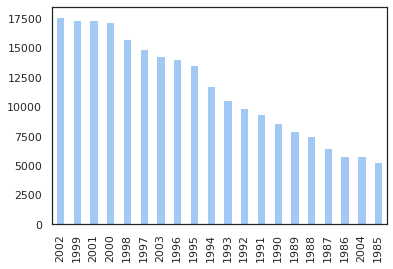

In [ ]:
# Anos de publicação Top 20
Ratings=df_book["Year-Of-Publication"].value_counts(ascending=False)
Ratings.head(20).plot.bar()
Ratings.head(20)



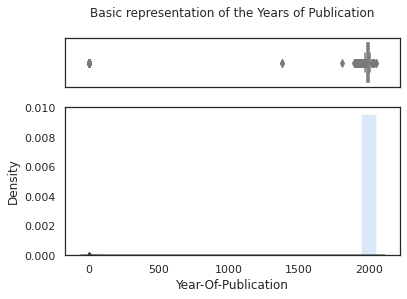

In [ ]:
#Histograma de pontos com toda base

#Subplot grid
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.25, 0.75)})
 
#Plot + subplot grid
sns.boxplot(df_book["Year-Of-Publication"], ax=ax_box).set_title("Basic representation of the Years of Publication\n")
sns.distplot(df_book["Year-Of-Publication"], ax=ax_hist, kde=False, fit=stats.gamma, bins=20)
sns.set_color_codes("bright")

#Legendas
ax_box.set(xlabel='') #Remove x axis name for the boxplot
ax_hist.set(ylabel='Density')

plt.show()

In [ ]:
Q3 = np.quantile(df_book["Year-Of-Publication"], 0.75) #Third quartile
Q1 = np.quantile(df_book["Year-Of-Publication"], 0.25) #First quartile
IQR = Q3 - Q1 #Inter Quartile Range
sns.set_color_codes("bright")

outlier_score_threshold =  Q3 + 1.5 * IQR
outlier_number=len(df_book[df_book["Year-Of-Publication"] > outlier_score_threshold ])

print("Number of outliers:", outlier_number,
      "\nOutlier proportion:", round(outlier_number/len(df_book_rating["Book-Rating"])*100, 3),"%",
      "\nOutlier threshold score:", outlier_score_threshold,"/ 100")

Number of outliers: 17 
Outlier proportion: 0.001 % 
Outlier threshold score: 2016.5 / 100


[(0.0, 0.05), (1940.0, 2050.0)]

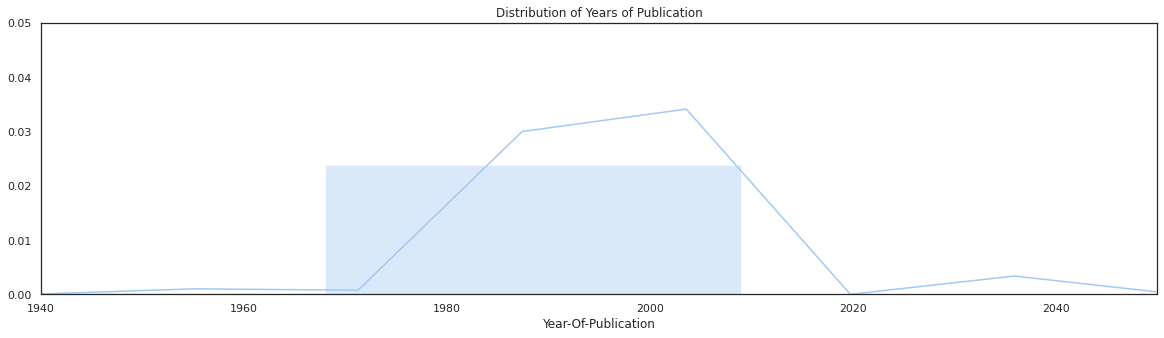

In [ ]:
#Histograma com distribuição dos anos de publicação
plt.figure(figsize=(20,5))
plt.title("Distribution of Years of Publication")
ax = sns.distplot(df_book["Year-Of-Publication"])
ax.set(xlim=(1940, 2050), ylim=(0, 0.05))


###2.3 Books Ratings

In [ ]:
#Verificando as estatísticas básicas
df_book_rating.describe(exclude=[np.object])

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [ ]:
#Entendendo se temos muitos valores faltantes
df_book_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [ ]:
total = df_book_rating.isnull().sum().sort_values(ascending = False)
percent = (df_book_rating.isnull().sum()/df_book_rating.isnull().count()*100).sort_values(ascending = False)
missing_df_book_rating  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_df_book_rating

,Total,Percent
Book-Rating,0,0.0
ISBN,0,0.0
User-ID,0,0.0


0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
Name: Book-Rating, dtype: int64

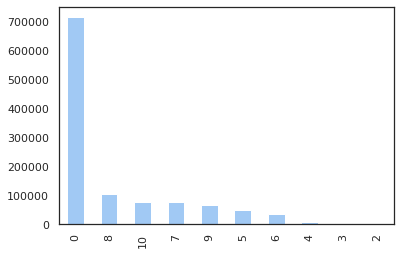

In [ ]:
# Ratings de 0 a 10
Ratings=df_book_rating["Book-Rating"].value_counts(ascending=False)
Ratings.head(10).plot.bar()
Ratings.head(10)



In [ ]:
total = df_book_rating["Book-Rating"].value_counts(ascending=False)
percent = (df_book_rating.count()/df_book_rating.count()*100).sort_values(ascending = False)
Ratings_percent  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
Ratings_percent

,Total,Percent
0,716109.0,NaN
1,1770.0,NaN
2,2759.0,NaN
3,5996.0,NaN
4,8904.0,NaN
5,50974.0,NaN
6,36924.0,NaN
7,76457.0,NaN
8,103736.0,NaN
9,67541.0,NaN


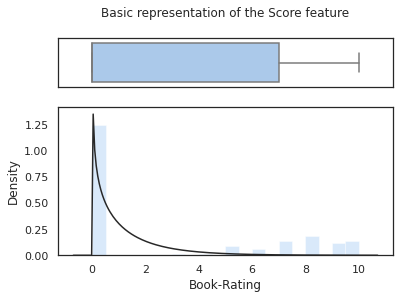

In [ ]:
#Histograma de pontos com toda base

#Subplot grid
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.25, 0.75)})
 
#Plot + subplot grid
sns.boxplot(df_book_rating["Book-Rating"], ax=ax_box).set_title("Basic representation of the Score feature\n")
sns.distplot(df_book_rating["Book-Rating"], ax=ax_hist, kde=False, fit=stats.gamma, bins=20)
sns.set_color_codes("bright")

#Legendas
ax_box.set(xlabel='') #Remove x axis name for the boxplot
ax_hist.set(ylabel='Density')

plt.show()

In [ ]:
Q3 = np.quantile(df_book_rating["Book-Rating"], 0.75) #Third quartile
Q1 = np.quantile(df_book_rating["Book-Rating"], 0.25) #First quartile
IQR = Q3 - Q1 #Inter Quartile Range
sns.set_color_codes("bright")

outlier_score_threshold =  Q3 + 1.5 * IQR
outlier_number=len(df_book_rating[ df_book_rating["Book-Rating"] > outlier_score_threshold ])

print("Number of outliers:", outlier_number,
      "\nOutlier proportion:", round(outlier_number/len(df_book_rating["Book-Rating"])*100, 3),"%",
      "\nOutlier threshold score:", outlier_score_threshold,"/ 100")

Number of outliers: 0 
Outlier proportion: 0.0 % 
Outlier threshold score: 17.5 / 100


[(0.0, 3.5), (-1.0, 11.0)]

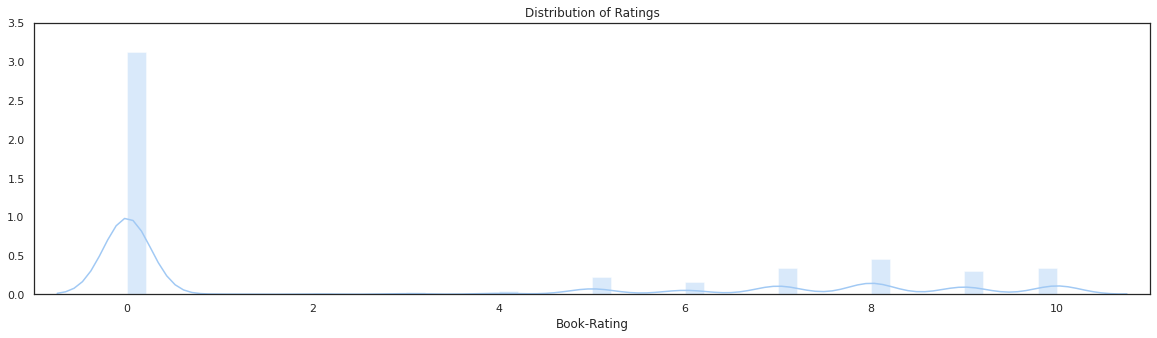

In [ ]:
#Histograma com distribuição dos Ratings
plt.figure(figsize=(20,5))
plt.title("Distribution of Ratings")
ax = sns.distplot(df_book_rating["Book-Rating"])
ax.set(xlim=(-1, 11), ylim=(0, 3.5))

# #################NORMALIZACAO DE DADOS

In [68]:
#Normalizacao de Location para poder fazer comparacao. Removendo espacos em blanco

df_users['Location_CY'] = df_users['Location_CY'].str.strip()
df_users

,User-ID,Location_CT,Location_UF,Location_CY,Age
0,120567,545,rheinland-pfalz,germany,NaN
1,84244,01109,sachsen,germany,40.0
2,151969,1700,fribourg,switzerland,24.0
3,147786,01721,NaN,NaN,37.0
4,160922,3003,tenerife,espaã±a,30.0
...,...,...,...,...,...
277659,257484,zwolle,overijssel,netherlands,25.0
277660,258249,zwolle,NaN,netherlands,26.0
277661,239223,zxcvzxcvzxcvz,abruzzo,italy,32.0
277662,146905,zywiec,slaskie,poland,22.0


In [69]:
# Procurando os usuario que sao do pais usa
import numpy as np
df_users_usa = df_users[(df_users['Location_CY'] == "usa")]
df_users_usa

,User-ID,Location_CT,Location_UF,Location_CY,Age
8,266829,05680,vermont,usa,NaN
13,155407,10012,new york,usa,NaN
14,198308,10458,new york,usa,46.0
18,223378,miami,florida,usa,17.0
20,130531,39180,mississippi,usa,25.0
...,...,...,...,...,...
277320,258411,zumbrota,minnesota,usa,NaN
277321,276509,zumbrots,minnesota,usa,NaN
277324,142979,zuni,virginia,usa,56.0
277325,143351,zuni,new mexico,usa,NaN


In [70]:
# Considerando so book rating com avaliacao explicita, o seja rating superior a 0
df_book_rating_no_zero = df_book_rating[(df_book_rating['Book-Rating'] > 0)]
df_book_rating_no_zero

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6
...,...,...,...
1149773,276704,0806917695,5
1149775,276704,1563526298,9
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [71]:
# Relacionando os usuarios de usa e as avaliacaoes que fizeram

merged_user_book_rating_df = pd.merge(left=df_users_usa, right=df_book_rating_no_zero, left_on='User-ID', right_on='User-ID')
merged_user_book_rating_df

,User-ID,Location_CT,Location_UF,Location_CY,Age,ISBN,Book-Rating
0,99955,lockport,new york,usa,14.0,0060256672,10
1,99955,lockport,new york,usa,14.0,0061032034,10
2,99955,lockport,new york,usa,14.0,0064401480,8
3,99955,lockport,new york,usa,14.0,0140031928,6
4,99955,lockport,new york,usa,14.0,0140328696,8
...,...,...,...,...,...,...,...
141287,199717,zion grove,pennsylvania,usa,24.0,0441569595,5
141288,220014,zionsville,indiana,usa,NaN,0312924585,8
141289,220014,zionsville,indiana,usa,NaN,0679742298,8
141290,11374,zionville,north carolina,usa,48.0,0671702513,4


In [72]:
# quantidade de usuarios unicos que avaliaram algum livro de forma explicita
users_who_evaluated = merged_user_book_rating_df['User-ID'].nunique()
users_who_evaluated

23814

In [73]:
# quantidade de livros avaliados de forma explicita
books_evaluated = merged_user_book_rating_df['ISBN'].nunique()
books_evaluated

70340

###2.1 Users (com normalização)

In [ ]:
#Verificando as estatísticas básicas
df_users_usa.describe

<bound method NDFrame.describe of        User-ID Location_CT                   Location_UF Location_CY   Age
8       266829       05680                       vermont         usa   NaN
13      155407       10012                      new york         usa   NaN
14      198308       10458                      new york         usa  46.0
18      223378       miami                       florida         usa  17.0
20      130531       39180                   mississippi         usa  25.0
...        ...         ...                           ...         ...   ...
277320  258411    zumbrota                     minnesota         usa   NaN
277321  276509    zumbrots                     minnesota         usa   NaN
277324  142979        zuni                      virginia         usa  56.0
277325  143351        zuni                    new mexico         usa   NaN
277663   51181       zzzzz  australian capital territory         usa   NaN

[139631 rows x 5 columns]>

In [ ]:
#Entendendo se temos muitos valores faltantes
df_users_usa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139631 entries, 8 to 277663
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   User-ID      139631 non-null  object 
 1   Location_CT  139523 non-null  object 
 2   Location_UF  139547 non-null  object 
 3   Location_CY  139631 non-null  object 
 4   Age          76483 non-null   float64
dtypes: float64(1), object(4)
memory usage: 6.4+ MB


In [ ]:
total = df_users_usa.isnull().sum().sort_values(ascending = False)
percent = (df_users_usa.isnull().sum()/df_users_usa.isnull().count()*100).sort_values(ascending = False)
missing_df_users_usa  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_df_users_usa

,Total,Percent
Age,63148,45.224914
Location_CT,108,0.077347
Location_UF,84,0.060159
Location_CY,0,0.000000
User-ID,0,0.000000


california        19633
texas              8206
new york           7733
florida            6923
pennsylvania       5891
illinois           5792
washington         5679
ohio               4563
michigan           4486
oregon             4229
virginia           4215
massachusetts      3878
missouri           3843
north carolina     3623
new jersey         3536
georgia            3302
minnesota          3009
colorado           2558
wisconsin          2522
maryland           2511
Name: Location_UF, dtype: int64

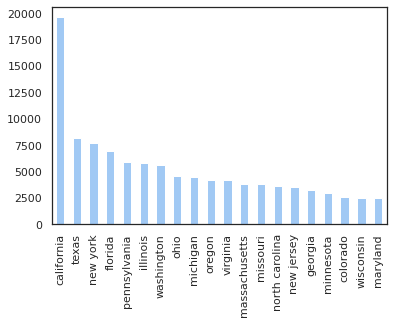

In [ ]:
# UF dos usuários
Users_USA_UF=df_users_usa["Location_UF"].value_counts(ascending=False)
Users_USA_UF.head(20).plot.bar()
Users_USA_UF.head(20)

34.0    2186
33.0    1982
35.0    1979
29.0    1928
32.0    1927
36.0    1848
24.0    1842
28.0    1835
31.0    1824
30.0    1822
26.0    1792
25.0    1788
27.0    1779
37.0    1689
23.0    1667
38.0    1647
39.0    1602
40.0    1563
41.0    1560
43.0    1545
Name: Age, dtype: int64

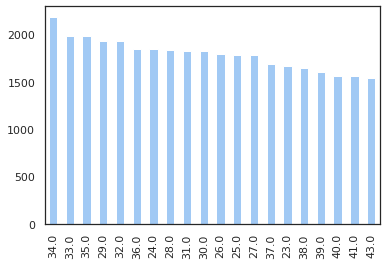

In [ ]:
# Idade dos usuários - aumentou bastante a idade média vs base full
Users_USA_Age=df_users_usa["Age"].value_counts(ascending=False)
Users_USA_Age.head(20).plot.bar()
Users_USA_Age.head(20)



[(0.0, 0.035), (1.0, 100.0)]

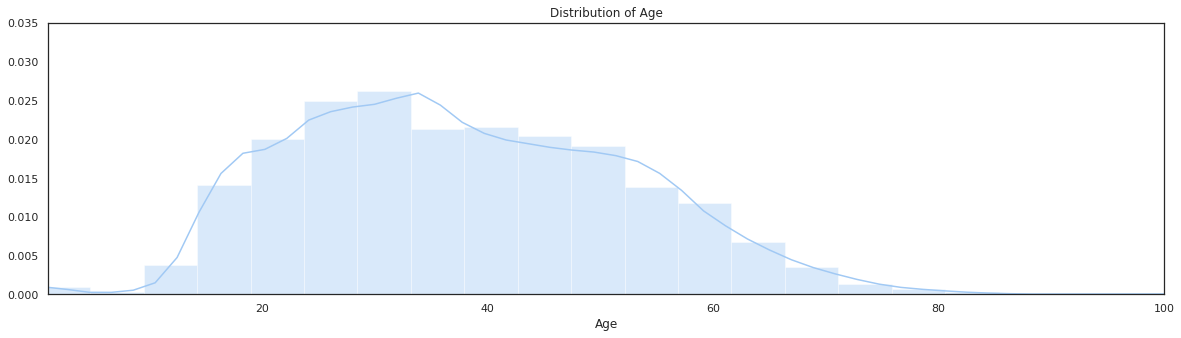

In [ ]:
#Histograma com distribuição de idade
plt.figure(figsize=(20,5))
plt.title("Distribution of Age")
ax = sns.distplot(df_users_usa["Age"])
ax.set(xlim=(1, 100), ylim=(0, 0.035))


## 3. Desenvolvimento Filtragem Colaborativa
Executaremos a filtragem com DL e sem DL, para depois compararmos as principais métricas:

**Qualidade de predição (acurácia)**
- Mean Absolute Error (MAE) - https://keras.io/api/metrics/regression_metrics/#meanabsoluteerror-class
- Mean Squared Error (MSE) / Loss - https://keras.io/api/metrics/regression_metrics/#meansquarederror-class
- Root Mean Square Error (RMSE) - https://keras.io/api/metrics/regression_metrics/#rootmeansquarederror-class 

**Conjunto de recomendações**
https://keras.io/api/metrics/classification_metrics/#auc-class 
Usar Fit and Score??
- Precisão (P) - proporção de recomendações consideradas boas
- Revocação (R ) - boas recomendações recuperadas pelo sistema
- F1 - média ponderada entre P e R.

**Lista de recomendação gerada**
- Half-life utility (R-Score) - mede a qualidade da lista gerada, ordenando os com maior fit no topo e vai descendo


### 3.1 - F.C. com Deep Learning

#Usando fast ai lib para filtragem colaborativo

### Adicionando titulo aos dados de booking rating

In [74]:
user_book_rating_with_tittle = merged_user_book_rating_df.merge(df_book[['ISBN', 'Book-Title']])
user_book_rating_with_tittle.head()

,User-ID,Location_CT,Location_UF,Location_CY,Age,ISBN,Book-Rating,Book-Title
0,99955,lockport,new york,usa,14.0,014038572X,10,The Outsiders (Now in Speak!)
1,97290,londonderry,new hampshire,usa,24.0,014038572X,6,The Outsiders (Now in Speak!)
2,179744,manchester,connecticut,usa,26.0,014038572X,8,The Outsiders (Now in Speak!)
3,152062,mchenry,illinois,usa,19.0,014038572X,9,The Outsiders (Now in Speak!)
4,27313,miami,florida,usa,14.0,014038572X,10,The Outsiders (Now in Speak!)


### Selecionando User-Is, ISBN, rating e Book-Title

In [75]:
user_book_with_rating_df = user_book_rating_with_tittle[['User-ID','ISBN','Book-Rating','Book-Title']]

In [76]:
from fastai.collab import *
from fastai.tabular import *

data = CollabDataBunch.from_df(user_book_with_rating_df, seed=42, valid_pct=0.1, item_name='Book-Title')
data.show_batch()

User-ID,Book-Title,target
46389,Making Herbal Dream Pillows : Secret Blends for Pleasant Dreams (The Spirit of Aromatherapy),8.0
232522,The London Fashion Book,10.0
113519,Having Our Say: The Delany Sisters' First 100 Years,8.0
182393,The Story of B,9.0
111490,Barefoot Doctor's Handbook for the Urban Warrior: a Spiritual Survival Guide,9.0


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


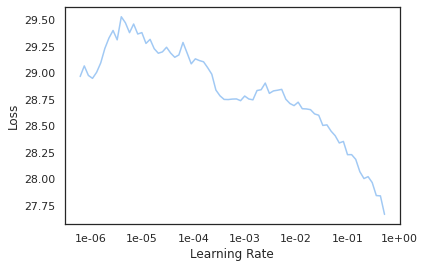

In [77]:
y_range = [0,5.5]
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [78]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,27.640923,27.894957,00:03
1,23.145224,24.127592,00:03
2,17.506199,22.281258,00:03
3,14.478722,21.693998,00:03
4,13.405917,21.595411,00:03


In [79]:
learn.save('dotprod')

### Interpretacao

In [80]:
# Configuracao
learn.load('dotprod');
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(6820, 40)
  (i_weight): Embedding(11034, 40)
  (u_bias): Embedding(6820, 1)
  (i_bias): Embedding(11034, 1)
)

In [81]:
g = user_book_with_rating_df.groupby('Book-Title')['Book-Rating'].count()
top_books = g.sort_values(ascending=False).index.values[:1000]
top_books[:10]

array(['A Painted House', "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))", 'Snow Falling on Cedars',
       'Harry Potter and the Order of the Phoenix (Book 5)',
       "The No. 1 Ladies' Detective Agency (Today Show Book Club #8)", 'The Firm', 'The Bridges of Madison County',
       'STONES FROM THE RIVER', 'A Child Called \\It\\": One Child\'s Courage to Survive"', "Bridget Jones's Diary"],
      dtype=object)

### Book bias

In [82]:
book_bias = learn.bias(top_books, is_item=True)
book_bias.shape

torch.Size([1000])

In [83]:
mean_ratings = user_book_with_rating_df.groupby('Book-Title')['Book-Rating'].mean()
book_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_books,book_bias)]

In [84]:
item0 = lambda o:o[0]

In [85]:
sorted(book_ratings, key=item0)[:15]

[(tensor(-0.0131), 'The Book Club', 3.3333333333333335),
 (tensor(0.0141), 'Black Coffee Blues', 3.0),
 (tensor(0.0592), "Let's Get Invisible! (Goosebumps, No 6)", 5.0),
 (tensor(0.0769), 'Lawless', 8.25),
 (tensor(0.0882), 'Embrace the Twilight', 8.75),
 (tensor(0.0911),
  'The Golden Compass (His Dark Materials, Book 1)',
  9.333333333333334),
 (tensor(0.0920), 'The Artistic Cat', 8.75),
 (tensor(0.0985), 'A Tangled Web', 7.0),
 (tensor(0.0986), 'The Good Men', 6.333333333333333),
 (tensor(0.1062), 'Blue Gold : A Novel from the NUMA Files', 5.0),
 (tensor(0.1124), 'Naughty Marietta', 7.0),
 (tensor(0.1142), 'Coldheart Canyon', 5.0),
 (tensor(0.1164), 'Brothers and Sisters', 6.333333333333333),
 (tensor(0.1177), 'CAT OUTER SPACE', 4.666666666666667),
 (tensor(0.1222), 'The Gift of Jazzy', 6.333333333333333)]

In [86]:
sorted(book_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(1.1049),
  "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))",
  8.840909090909092),
 (tensor(1.0662), 'A Painted House', 7.445161290322581),
 (tensor(1.0151), 'Snow Falling on Cedars', 7.822916666666667),
 (tensor(0.9728),
  'Harry Potter and the Order of the Phoenix (Book 5)',
  9.121951219512194),
 (tensor(0.9238), 'The Firm', 8.069444444444445),
 (tensor(0.9060),
  "The No. 1 Ladies' Detective Agency (Today Show Book Club #8)",
  8.0),
 (tensor(0.8507), 'The Bridges of Madison County', 7.904761904761905),
 (tensor(0.8489), 'STONES FROM THE RIVER', 7.951612903225806),
 (tensor(0.8359),
  'A Child Called \\It\\": One Child\'s Courage to Survive"',
  8.125),
 (tensor(0.8234),
  "The Color of Water: A Black Man's Tribute to His White Mother",
  8.520833333333334),
 (tensor(0.8169), 'Bag of Bones', 7.926829268292683),
 (tensor(0.8109), 'The Rainmaker', 7.3090909090909095),
 (tensor(0.8057),
  'Face the Fire (Three Sisters Island Trilogy)',
  8.179487179487179),


### Book weights

In [87]:
book_w = learn.weight(top_books, is_item=True)
book_w.shape

torch.Size([1000, 40])

In [88]:
book_pca = book_w.pca(3)
book_pca.shape

torch.Size([1000, 3])

In [89]:
fac0,fac1,fac2 = book_pca.t()
book_comp = [(f, i) for f,i in zip(fac0, top_books)]

In [90]:
sorted(book_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(3.0927), 'A Painted House'),
 (tensor(2.7995),
  "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))"),
 (tensor(2.4643),
  "The No. 1 Ladies' Detective Agency (Today Show Book Club #8)"),
 (tensor(2.3102), 'Snow Falling on Cedars'),
 (tensor(2.1219), 'The Firm'),
 (tensor(1.9734), 'Tears of the Giraffe (No.1 Ladies Detective Agency)'),
 (tensor(1.9713), 'Girl in Hyacinth Blue'),
 (tensor(1.8254), 'Harry Potter and the Order of the Phoenix (Book 5)'),
 (tensor(1.7397), 'How to Be Good'),
 (tensor(1.6767), "Bridget Jones's Diary")]

In [91]:
sorted(book_comp, key=itemgetter(0))[:10]

[(tensor(-0.9988), 'Manifold: Time (Manifold (Paperback))'),
 (tensor(-0.8474), 'Bi Any Other Name:  Bisexual People Speak Out'),
 (tensor(-0.8139), 'That End of Lilac Lane'),
 (tensor(-0.7622), 'Filthy Rich'),
 (tensor(-0.7334), 'In Patagonia'),
 (tensor(-0.7168), 'One Hundred Years of Solitude'),
 (tensor(-0.7112), 'Crossing Over'),
 (tensor(-0.7091), 'Eat Right for Your Type'),
 (tensor(-0.6821),
  'Taste Berries for Teens - Inspirational short stories and encouragement on life, love, friendship and tough issues'),
 (tensor(-0.6726), 'The Monkey Wrench Gang')]

In [92]:
book_comp = [(f, i) for f,i in zip(fac1, top_books)]

In [93]:
sorted(book_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8937), 'Lake News'),
 (tensor(0.8935),
  'Like Water for Chocolate : A Novel in Monthly Installments with Recipes, Romances, and Home Remedies'),
 (tensor(0.8875), 'Four Blondes'),
 (tensor(0.7999),
  "The No. 1 Ladies' Detective Agency (Today Show Book Club #8)"),
 (tensor(0.7867), 'My Antonia'),
 (tensor(0.7462), 'Welcome to the World, Baby Girl!'),
 (tensor(0.7355), "Operating Instructions: A Journal of My Son's First Year"),
 (tensor(0.7076), 'What Looks Like Crazy On An Ordinary Day'),
 (tensor(0.6869), 'Prozac Nation: Young and Depressed in America : A Memoir'),
 (tensor(0.6859), "The Shelters of Stone (Earth's Children, Book 5)")]

In [94]:
sorted(book_comp, key=itemgetter(0))[:10]

[(tensor(-1.3860), 'Face the Fire (Three Sisters Island Trilogy)'),
 (tensor(-1.2831), 'Flesh and Blood'),
 (tensor(-1.2292), 'Key of Light (Key Trilogy (Paperback))'),
 (tensor(-1.0576), 'Beach House'),
 (tensor(-1.0418), 'The Client'),
 (tensor(-1.0404), 'A Painted House'),
 (tensor(-1.0187), '16 Lighthouse Road'),
 (tensor(-1.0033), 'Dream Country'),
 (tensor(-0.9889), 'Purity in Death'),
 (tensor(-0.9821), 'Rising Tides')]

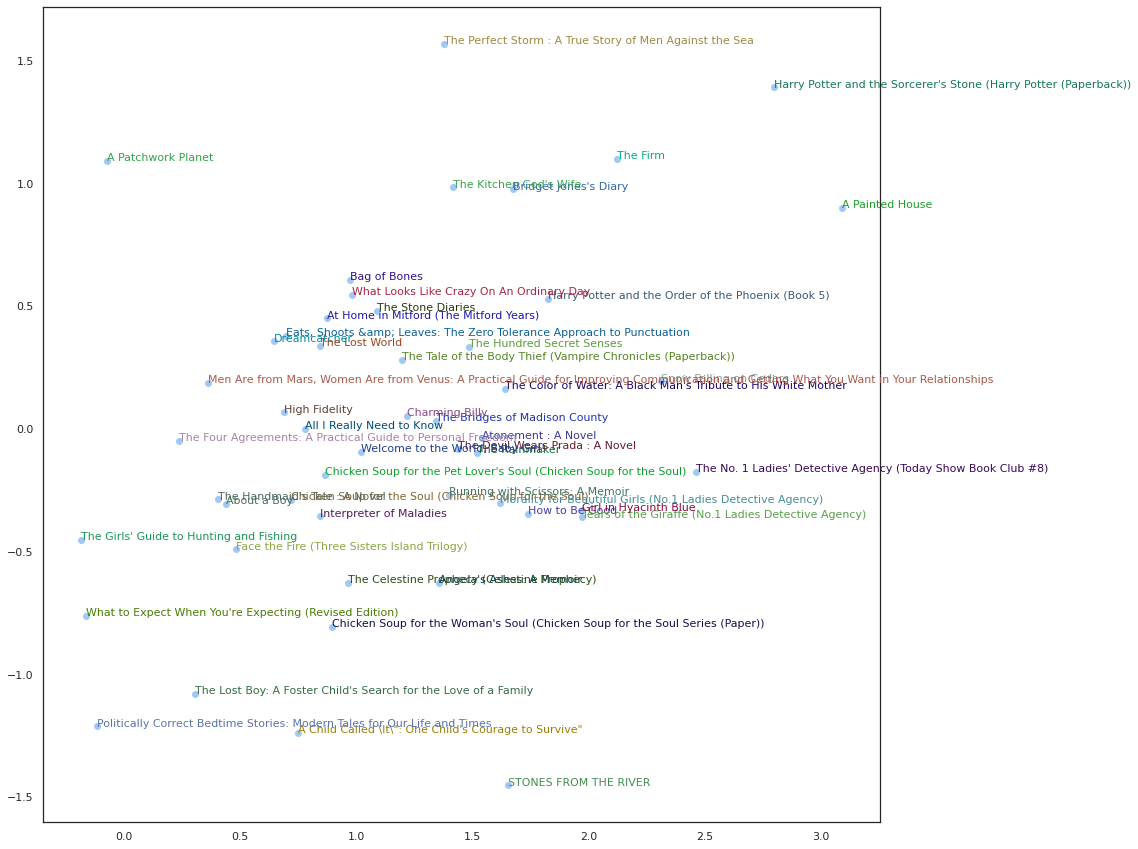

In [95]:
idxs = np.random.choice(len(top_books), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_books[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Usando keras

In [96]:
#https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929
import sklearn as sk
from sklearn.preprocessing import LabelEncoder

user_enc = LabelEncoder()
merged_user_book_rating_df['userUniq'] = user_enc.fit_transform(merged_user_book_rating_df['User-ID'].values)
n_users = merged_user_book_rating_df['userUniq'].nunique()

book_enc = LabelEncoder()
merged_user_book_rating_df['bookUniq'] = book_enc.fit_transform(merged_user_book_rating_df['ISBN'].values)
n_books = merged_user_book_rating_df['bookUniq'].nunique()

merged_user_book_rating_df['Book-Rating'] = merged_user_book_rating_df['Book-Rating'].values.astype(np.float32)
min_rating = min(merged_user_book_rating_df['Book-Rating'])
max_rating = max(merged_user_book_rating_df['Book-Rating'])

n_users, n_books, min_rating, max_rating

(23814, 70340, 1.0, 10.0)

In [97]:
from sklearn.model_selection import train_test_split

X = merged_user_book_rating_df[['userUniq', 'bookUniq']].values
y = merged_user_book_rating_df['Book-Rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((127162, 2), (14130, 2), (127162,), (14130,))

In [98]:
n_factors = 40
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [102]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot, Add, Activation, Lambda
from keras.optimizers import Adam
from keras.regularizers import l2

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

def Recommender(n_users, n_books, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    book = Input(shape=(1,))
    m = EmbeddingLayer(n_books, n_factors)(book)
    mb = EmbeddingLayer(n_books, 1)(book)
    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, book], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [103]:
model = Recommender(n_users, n_books, n_factors, min_rating, max_rating)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 40)        952560      input_5[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 40)        2813600     input_6[0][0]                    
____________________________________________________________________________________________

In [104]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 127162 samples, validate on 14130 samples
Epoch 1/5
127162/127162 [==============================] - 18s 138us/step - loss: 6.7984 - val_loss: 5.7746
Epoch 2/5
127162/127162 [==============================] - 17s 136us/step - loss: 4.3158 - val_loss: 4.5775
Epoch 3/5
127162/127162 [==============================] - 17s 136us/step - loss: 2.3937 - val_loss: 4.1971
Epoch 4/5
127162/127162 [==============================] - 17s 136us/step - loss: 1.3498 - val_loss: 4.0747
Epoch 5/5
127162/127162 [==============================] - 17s 136us/step - loss: 0.8229 - val_loss: 4.0333


### 3.2 - F.C. sem Deep Learning

## 4. Comparativo e análise
Verificamos as principais métricas dos dois algoritmos, comparando e identificando diferenças

## 5. Conclusão
Fechamos o trabalho com a percepção final sobre os 2 modelos executados.